# Biophysics Problem Set 2 -- Master Equations Simulations

## Name: William Cerny
## Due Date: 5/4/20

In [1]:
## necessary packages
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import animation
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize, LogNorm
import warnings as w
w.filterwarnings('ignore')

# Gillespie Simulation

In [2]:
def chooseReaction(p,g,n, verbose = False):
    '''
    Randomly chooses whether to produce or to degrade for a given time. Assumes both probabilities are < 1, 
    so that they sum to 1.
    '''
    
    p_degrade = (g * n)/((g * n) + p)
    p_produce = 1. - p_degrade

    randomNumber = np.random.uniform(0.,1.)

    if verbose == True: print('Degrade Probability = %.2f percent and Produce Probability = %.2f percent' \
          %(p_degrade * 100, p_produce *100))
    
    
    if randomNumber <= p_degrade: 
        if verbose == True: print('Random Number was %f, so degrading since p_deg = %f'%(randomNumber,p_degrade))
        return -1 
    elif randomNumber > p_degrade: 
        if verbose == True: print('Random Number was %f, so producing since p_deg = %f'%(randomNumber,p_degrade))
        return 1

In [3]:
def chooseTimeIncrement(p,g,n, verbose = False):
    '''
    Calculates the mean of the time step distribution and then 
    '''
    
    mean = 1. / ((g * n) + p )
    return np.random.exponential(1/mean)

In [4]:
def runSimulation(startConcentration, startTime, prodrate, degradeRate, simlength):
    '''
    Runs a simulation given a starting concentration and starting time, and production and degradation rate.
    Simulation stops after (simlength) timesteps
    '''
    assert degradeRate >= 0 
    runningConc = startConcentration
    elapsedTime = startTime
    history = []
    
    for i in range(simlength):
        history.append((runningConc,elapsedTime))
        reactiontype = chooseReaction(p = prodrate, g = degradeRate,  n = runningConc)
       
        #print('Before',runningConc, end = ':')
      

        if reactiontype == 1: runningConc += 1 
        if reactiontype == -1: runningConc -= 1
        timestep = chooseTimeIncrement(p = prodrate, g = degradeRate,  n = runningConc)
        #print('  After:', runningConc)
        #print('Timestep',timestep)
        elapsedTime += timestep
    
    return history


In [5]:
startConcentration = 0
startTime = 0
history = []

history = runSimulation(startConcentration = startConcentration, startTime= startTime, \
                        prodrate= 20, degradeRate= .5, simlength = 10000)


In [6]:
concs = [a for (a,b) in history]
running_time = [b for (a,b) in history]

(0, 80)

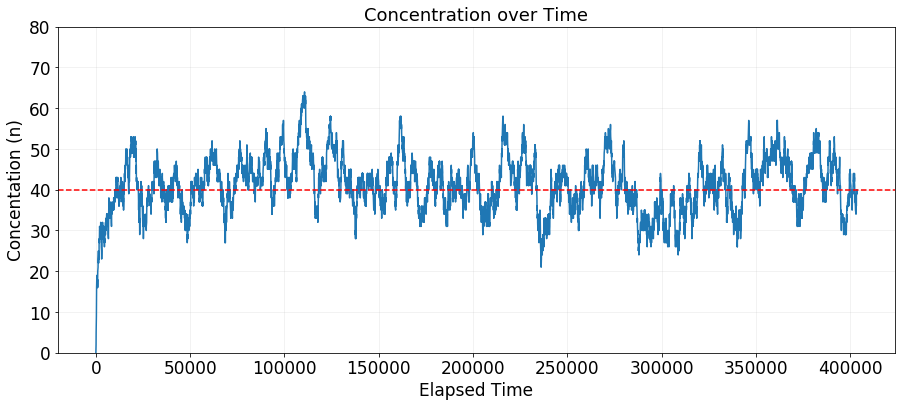

In [7]:
plt.figure(figsize = (15,6))
plt.plot(running_time, concs)

plt.grid(alpha = .2)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylabel('Concentation (n)',fontsize = 17)
plt.xlabel('Elapsed Time',fontsize = 17)
plt.title('Concentration over Time',fontsize = 18)
plt.axhline(40, color = 'red', ls ='--')
plt.ylim(0,80)

### Subset the History Array to Look at Steady State Distribution:

In [8]:
## select some large time where it looks like the above is at steady state

index = np.where(np.array(running_time) > 50000)[0] 
print('Steady State timestep index:',index.min(), 'which is circa t= ',running_time[index.min()])
history_subset = history[index.min():]
subset_concs = [a for (a,b) in history_subset]

Steady State timestep index: 1297 which is circa t=  50010.63064475543


### Generate a very rough Poisson curve to compare against:

In [9]:
from scipy.special import factorial
x = np.linspace(0 ,80 ,500)
y = np.power(40,x) *np.exp(-40) / factorial(x) ## the "40" is the ratio p/g

### Plot both the theoretical and actual distributions for comparison

(0, 0.07)

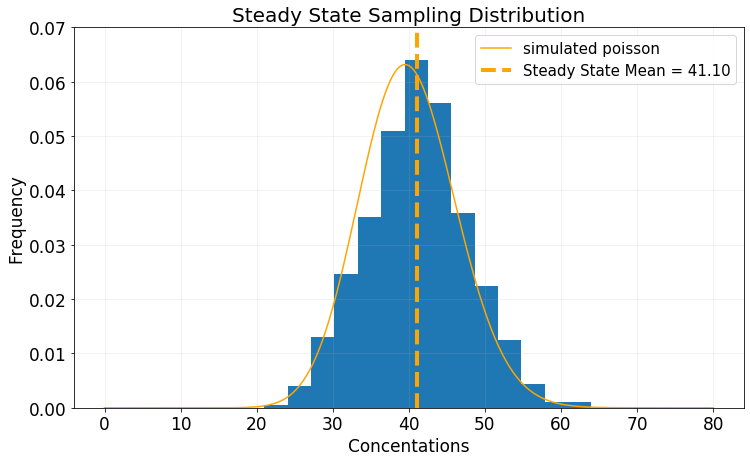

In [17]:
plt.figure(figsize = (12,7))

_ = plt.hist(subset_concs, bins = 14,density = True)
plt.grid(alpha = .2)
_ =plt.xticks(fontsize = 17)
_ =plt.yticks(fontsize = 17)
plt.ylabel('Frequency',fontsize = 17)
plt.xlabel('Concentations',fontsize = 17)
plt.title('Steady State Sampling Distribution',fontsize = 20)
mean = np.mean(subset_concs)
plt.plot(x,y, color = 'orange', label = 'simulated poisson')
plt.axvline(mean, color = 'orange', ls = '--', lw = 4,label = 'Steady State Mean = %.2f'%mean)
plt.legend(loc = 'upper right',fontsize = 15)
plt.ylim(0,.07)

Check the variance of the above distribution:

In [11]:
np.var(subset_concs)

42.070049369698204

### While not perfectly equal such that mean = variance = 40, it is clear that the resulting distribution has approximately this condition met, with mean = 41.10 and variance = 42.07, and thus it is safe to conclude that the numerically derived result above is Poisson. This is consistent with what was found in the analytical portion of this assignment. Some deviation from a perfect Poisson distribution like the one in the analytic portion of the assigment could be due to the fact that this computational model does not have a no reaction scenario 

### As to why exactly this is not a perfect Poisson distribution, it could be the case that the exact location at which the particle is deemed to be at steady state is incorrectly estimated; more likely, however, is the possibility that the variance is being artifically elevated by outliers, since variance is a "residual squared" quantity which means that observations distance from the distribution mean are weighted more highly. The particularly strong peak early at t~= 120,000 and the strong dip could be causing this, for example, although it is a bit hard to judge.